In [1]:
import numpy as np
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt
import yfinance as yf


In [3]:
assets = ["AAPL", "MSFT", "GOOGL"]
start = "2019-01-01"
end = "2024-01-01"

prices = yf.download(
    assets,
    start=start,
    end=end,
    auto_adjust=True
)["Close"]

prices.dropna(inplace=True)
prices.head()


[*********************100%***********************]  3 of 3 completed


Ticker,AAPL,GOOGL,MSFT
Date,,,
2019-01-02,37.538815,52.338543,94.612610
2019-01-03,33.799671,50.888996,91.132011
2019-01-04,35.242565,53.499271,95.370476
2019-01-07,35.164124,53.392582,95.492111
2019-01-08,35.834454,53.861542,96.184502


In [4]:
returns = prices.pct_change().dropna()

mu = returns.mean().values          # expected returns
Sigma = returns.cov().values        # covariance matrix

n = len(mu)

mu, Sigma


(array([0.00150012, 0.00097614, 0.00127101]),
 array([[0.00041233, 0.00027463, 0.00029588],
        [0.00027463, 0.00040154, 0.00029213],
        [0.00029588, 0.00029213, 0.00036893]]))

In [5]:
lambdas = np.linspace(0.01, 10, 50)


In [6]:
weights_list = []
portfolio_returns = []
portfolio_risks = []

for lam in lambdas:
    w = cp.Variable(n)

    risk = cp.quad_form(w, Sigma)
    ret = mu @ w

    objective = cp.Minimize(lam * risk - ret)
    constraints = [
        cp.sum(w) == 1,
        w >= 0
    ]

    problem = cp.Problem(objective, constraints)
    problem.solve()

    w_val = w.value
    weights_list.append(w_val)

    portfolio_returns.append(mu @ w_val)
    portfolio_risks.append(np.sqrt(w_val.T @ Sigma @ w_val))


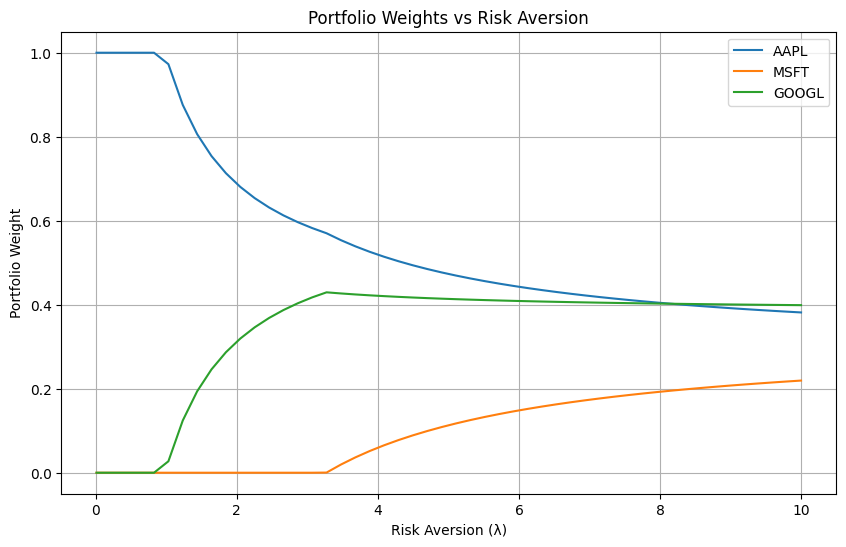

In [7]:
weights_array = np.array(weights_list)

plt.figure(figsize=(10,6))
for i, asset in enumerate(assets):
    plt.plot(lambdas, weights_array[:, i], label=asset)

plt.xlabel("Risk Aversion (λ)")
plt.ylabel("Portfolio Weight")
plt.title("Portfolio Weights vs Risk Aversion")
plt.legend()
plt.grid(True)
plt.show()


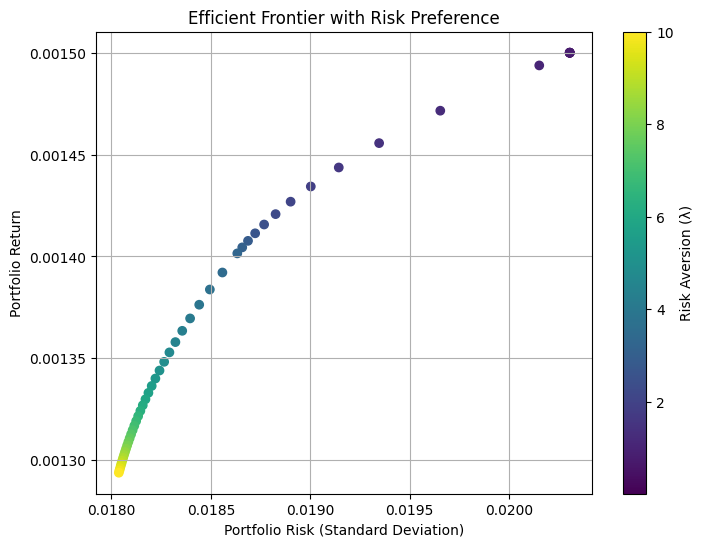

In [8]:
plt.figure(figsize=(8,6))
plt.scatter(portfolio_risks, portfolio_returns, c=lambdas, cmap="viridis")
plt.colorbar(label="Risk Aversion (λ)")
plt.xlabel("Portfolio Risk (Standard Deviation)")
plt.ylabel("Portfolio Return")
plt.title("Efficient Frontier with Risk Preference")
plt.grid(True)
plt.show()


### Observations

- Lower values of λ correspond to more risk-seeking portfolios with higher exposure to risky assets.
- Higher values of λ lead to more conservative portfolios with lower overall risk.
- Portfolio weights change smoothly as investor risk preference varies.
- This demonstrates that optimal portfolios depend strongly on individual risk appetite.
